# Make Dataset

- sample positve class
- sample negative class
- refine negative

In [31]:
# Autorelaod
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import igraph as ig
import leidenalg
from scipy.special import softmax
import re
from statsmodels.stats.multitest import multipletests

os.chdir("/home/gdallagl/myworkdir/ESMSec")
print(f"Working directory successfully changed to: {os.getcwd()}")

import utils.my_functions as mf
import utils.dataset_functions as dataf

config_file="/home/gdallagl/myworkdir/ESMSec/config/config.yaml"
config = mf.load_config(config_file)

mf.set_all_seeds(config["random_seed"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Working directory successfully changed to: /home/gdallagl/myworkdir/ESMSec
Seeds set successfully to 42 for random, numpy, and PyTorch (if used).


# Load definitive positive genes

In [2]:
positive_genes_df = pd.read_csv(config["data_paths"]["final_positive_genes"])
display(positive_genes_df)
positive_genes = set(positive_genes_df[positive_genes_df.definitive_positive == True].gene)
ambiguos_genes = set(positive_genes_df[positive_genes_df.definitive_positive == False].gene)
print("Number positive genes", len(positive_genes))
print("Number ambiguos genes", len(ambiguos_genes))

gene  geneset_count  is_guaranteed     label  geneset_percent  \
0       EIF4E             15          False  positive         5.154639   
1        DPF1             15          False  positive         5.154639   
2       CENPL             15          False  positive         5.154639   
3         BID             15          False  positive         5.154639   
4       BCL7C             15          False  positive         5.154639   
...       ...            ...            ...       ...              ...   
7289    MPZL1              2          False  ambigous         0.687285   
7290  MPV17L2              2          False  ambigous         0.687285   
7291     MPST              2          False  ambigous         0.687285   
7292     MPP1              2          False  ambigous         0.687285   
7293     MRRF              2          False  ambigous         0.687285   

      p_by_std  p_by_wilcoxon  p_by_broad  n_positive  definitive_positive  
0         True           True        True           3                 True  
1         True           True        True           3                 True  
2         True           True        True           3                 True  
3         True           True        True           3                 True  
4         True           True        True           3                 True  
...        ...            ...         ...         ...                  ...  
7289     False          False       False           0                False  
7290     False          False       False           0                False  
7291     False          False       False           0                False  
7292     False          False       False           0                False  
7293     False          False       False           0                False  

[7294 rows x 10 columns]

Number positive genes 392
Number ambiguos genes 6902


In [3]:
# Create mapping positive_gene --> number genesets

# make postive gene-freq mapping
    # Filter ONLY positive genes
tmp = positive_genes_df[positive_genes_df["definitive_positive"] == True]

# Create a mapping: gene -> frequency
positive_gene_freq_map = dict(zip(tmp["gene"], tmp["geneset_count"]))
positive_gene_freq_map

{'EIF4E': 15,
 'DPF1': 15,
 'CENPL': 15,
 'BID': 15,
 'BCL7C': 15,
 'UBE2T': 16,
 'UBC': 16,
 'UBA52': 16,
 'TMOD3': 16,
 'TIMELESS': 16,
 'RPS27A': 16,
 'RANGAP1': 16,
 'RAD51AP1': 16,
 'PSMD2': 16,
 'PSMC2': 16,
 'GMNN': 23,
 'OFD1': 16,
 'NUDC': 16,
 'HMMR': 16,
 'GINS2': 16,
 'EXO1': 16,
 'ANAPC16': 16,
 'ZFP36L1': 17,
 'XPO1': 17,
 'TUBA1B': 17,
 'TFDP2': 17,
 'RPA3': 17,
 'PSMD11': 17,
 'ODF2': 17,
 'NCAPG2': 17,
 'KIF2A': 17,
 'ORC6': 16,
 'PSME2': 14,
 'PBK': 14,
 'PAF1': 14,
 'MCM10': 14,
 'HSPA1B': 14,
 'HSPA1A': 14,
 'HMGB3': 14,
 'HAUS1': 14,
 'E2F5': 14,
 'DYNLL1': 14,
 'DTYMK': 14,
 'DHFR': 14,
 'CEP152': 14,
 'CENPQ': 14,
 'CENPN': 14,
 'KIF18B': 15,
 'ARF6': 14,
 'TMPO': 15,
 'STMN1': 15,
 'RMI2': 15,
 'RHOA': 15,
 'RANBP1': 15,
 'RAN': 15,
 'PSME1': 15,
 'PSMD8': 15,
 'PSMD1': 15,
 'PSMC6': 15,
 'PSMC3': 15,
 'PSMB3': 15,
 'PSMA4': 15,
 'LMNB1': 15,
 'BCL7B': 14,
 'RDX': 21,
 'NCAPD3': 21,
 'KMT2E': 21,
 'KANK2': 21,
 'JADE1': 21,
 'EME1': 21,
 'ASPM': 21,
 'TYMS': 22,

# Define set of allowed proteins for the analyss

Focus only on:
- human
- reviwed
- no isoforms

In [4]:
proteome_uniprot = pd.read_csv(config["data_paths"]["human_proteome_uniprot"], sep="\t")

# ONLY Human 
    # csv file alredy fitered by species

# ONLY swissprot
if config["dataset_creation"]["use_only_reviewed_proteins"]:
    proteome_uniprot_reviewed = proteome_uniprot[proteome_uniprot.Reviewed == "reviewed"].copy()
    print("reviewed shape: ", proteome_uniprot_reviewed.shape)

# No isofrom, use canonical protein
proteome_uniprot_reviewed['IsIsoform'] = proteome_uniprot_reviewed['Entry'].str.contains(r'-\d+$')
n_isoforms = proteome_uniprot_reviewed['IsIsoform'].sum()
n_total = len(proteome_uniprot_reviewed)
print(f"Isoforms: {n_isoforms} / {n_total} ({n_isoforms/n_total:.2%})")

# Define proteins to use in the follwing analasys
allowed_proteins = set(proteome_uniprot_reviewed.Entry)
print("Number allowed proteins: ", len(allowed_proteins))
print(*list(allowed_proteins)[:10], "...")

reviewed shape:  (20405, 7)
Isoforms: 0 / 20405 (0.00%)
Number allowed proteins:  20405
Q8WXE9 Q6Y2X3 P25789 Q9BWJ5 Q8WVZ7 O14521 Q9UNX9 Q6ICC9 Q71UI9 Q9Y5G4 ...


In [5]:
# # ATTENTION: same protein can have mutliple genes
# print("Gens mapping to Q9P1J3 -->", proteome_uniprot[proteome_uniprot["Entry"] == "Q9P1J3"]["Gene Names"].values)

# # ATTENTION: soem proteins can have Nan geens
# display(proteome_uniprot[proteome_uniprot["Entry"] == "Q9N2K0"])

# # ATTNETION: are there ducplatd proteins
# print("number duplicated proteins:", proteome_uniprot_reviewed.Entry.duplicated().sum())


# Create Protein -  Gene - Uniref50 Mapping

In [13]:
# Read uniport ID mapping
uniprot_id_mapping_df = pd.read_csv(config["data_paths"]["uniprot_mapping_id"], sep='\t', header=None, names=['UniProtKB_Accession', 'ID_Type', 'External_ID'])
#print(uniprot_id_mapping_df.ID_Type.unique())
uniprot_id_mapping_df.head(2)

UniProtKB_Accession       ID_Type  External_ID
0              P31946  UniProtKB-ID  1433B_HUMAN
1              P31946     Gene_Name        YWHAB

In [14]:
# select protein and gene IDs
protein2uniref = uniprot_id_mapping_df[uniprot_id_mapping_df.ID_Type == "UniRef50"].copy()
gene2protein = uniprot_id_mapping_df[uniprot_id_mapping_df.ID_Type == "Gene_Name"].copy()

# filter only allowed proteins
protein2uniref = protein2uniref[protein2uniref.UniProtKB_Accession.isin(allowed_proteins)]
gene2protein = gene2protein[gene2protein.UniProtKB_Accession.isin(allowed_proteins)]

# raname
protein2uniref = (
    protein2uniref
    .rename(columns={"UniProtKB_Accession": "protein", "External_ID": "UniRef50_Cluster"})
    .drop(columns=["ID_Type"])
)
gene2protein = (
    gene2protein
    .rename(columns={"UniProtKB_Accession": "protein", "External_ID": "gene"})
    .drop(columns=["ID_Type"])
)
display(protein2uniref)
display(gene2protein)

protein UniRef50_Cluster
13       P31946  UniRef50_P31946
131      P62258  UniRef50_P62258
273      Q04917  UniRef50_Q04917
377      P61981  UniRef50_P61981
541      P31947  UniRef50_P31947
...         ...              ...
1868137  Q6WRX3  UniRef50_Q6WRX3
1868192  Q9C0D3  UniRef50_Q9C0D3
1868268  Q15942  UniRef50_Q15942
1868355  O43149  UniRef50_O43149
1868431  Q8IYH5  UniRef50_Q8IYH5

[20402 rows x 2 columns]

protein    gene
1        P31946   YWHAB
120      P62258   YWHAE
251      Q04917   YWHAH
342      P61981   YWHAG
470      P31947     SFN
...         ...     ...
1868129  Q6WRX3  ZYG11A
1868183  Q9C0D3  ZYG11B
1868246  Q15942     ZYX
1868344  O43149   ZZEF1
1868408  Q8IYH5    ZZZ3

[20397 rows x 2 columns]

In [15]:
# Create gene-protein mapping

# Add gene name to protein
uniref_df = pd.merge(how="inner", left=gene2protein, right=protein2uniref, on="protein")

# ATTENTION
    # protein --> mapped to multiple genes 
        # (ex. special gene mutation, but same protein name)
    # gene --> mapped to multiple protein
        # (ex. isofoms) --> took care before (allowed_gene filtering)
        # (ex. differt proteins)
print("number duplciated proteins: ", uniref_df.protein.duplicated().sum()) # no protesin mapped to multiple genes
print("number duplciated genes: ", uniref_df.gene.duplicated().sum())

duplicated_proteins = uniref_df[uniref_df["protein"].duplicated(keep=False)]
duplicated_genes = uniref_df[uniref_df["gene"].duplicated(keep=False)]

display(duplicated_genes)
display(duplicated_proteins)

number duplciated proteins:  127
number duplciated genes:  83


protein    gene UniRef50_Cluster
558    O43687   AKAP7  UniRef50_O43687
559    Q9P0M2   AKAP7  UniRef50_Q6JP77
611    P84996    GNAS  UniRef50_Q6R0H6
896    C0HMD6   PIDD1  UniRef50_C0HMD6
932    F7VJQ1    PRNP  UniRef50_F7VJQ1
...       ...     ...              ...
19243  P63131  ERVK-7  UniRef50_Q9Y6I0
19244  P63122  ERVK-8  UniRef50_P10265
19245  P63127  ERVK-9  UniRef50_P63128
19932  Q70YC5  ZNF365  UniRef50_Q70YC5
20142  Q96CS4  ZNF689  UniRef50_Q99PJ7

[136 rows x 3 columns]

protein    gene UniRef50_Cluster
1044   Q8IVW1  ARL17A  UniRef50_Q8IVW1
1045   Q8IVW1  ARL17B  UniRef50_Q8IVW1
1676   Q9H3K6   BOLA2  UniRef50_Q9H3K6
1677   Q9H3K6  BOLA2B  UniRef50_Q9H3K6
2284   Q8NHW4  CCL4L1  UniRef50_P10147
...       ...     ...              ...
19153  O14599    BPY2  UniRef50_O14599
19154  O14599   BPY2B  UniRef50_O14599
19155  O14599   BPY2C  UniRef50_O14599
19467  Q9HD64  XAGE1A  UniRef50_Q9HD64
19468  Q9HD64  XAGE1B  UniRef50_Q9HD64

[197 rows x 3 columns]

In [16]:
# REMOVE PORTEIN DUPLICATES

# Subset protein with mutliple gene to have only one gene
    # take it randomly
    # BUT sample before a gene from "postiev_gene" if rpesent

# add a helper column to mark whether the gene is "positive"
uniref_df["is_positive"] = uniref_df["gene"].isin(positive_genes)

# sort so that positive ones come first for each protein
uniref_df = uniref_df.sort_values(["protein", "is_positive"], ascending=[True, False])

# drop duplicates, keeping the first (which will be the positive one if it exists)
    # ATTENTION: if there are multiple postive genes, you will lose some !!!
uniref_df = uniref_df.drop_duplicates(subset="protein", keep="first")

# drop the helper column if no longer needed
uniref_df = uniref_df.drop(columns=["is_positive"])

In [17]:
# REMOVE GENES DUPLICATED

# Subset genes with mutliple protein to have only one protein
    # take it randomly
    # BUT sample before a gene from "postiev_gene" if rpesent
uniref_df["is_positive"] = uniref_df["gene"].isin(positive_genes)
uniref_df = uniref_df.sort_values(["gene", "is_positive"], ascending=[True, False])
uniref_df = uniref_df.drop_duplicates(subset="gene", keep="first")
uniref_df = uniref_df.drop(columns=["is_positive"])

In [18]:
# final check
print("number duplciated proteins: ", uniref_df.protein.duplicated().sum()) # no protesin mapped to multiple genes
print("number duplciated genes: ", uniref_df.gene.duplicated().sum())
uniref_df

number duplciated proteins:  0
number duplciated genes:  0


protein     gene UniRef50_Cluster
72     P04217     A1BG  UniRef50_P04217
73     Q9NQ94     A1CF  UniRef50_Q9NQ94
83     P01023      A2M  UniRef50_P01023
84     A8K2U0    A2ML1  UniRef50_A8K2U0
86     U3KPV4  A3GALT2  UniRef50_U3KPV4
...       ...      ...              ...
20389  Q6WRX3   ZYG11A  UniRef50_Q6WRX3
20390  Q9C0D3   ZYG11B  UniRef50_Q9C0D3
20391  Q15942      ZYX  UniRef50_Q15942
20392  O43149    ZZEF1  UniRef50_O43149
20393  Q8IYH5     ZZZ3  UniRef50_Q8IYH5

[20184 rows x 3 columns]

# Create Uniref50 Clusters

UniRef50_Cluster                                            protein  \
11076  UniRef50_Q86YD7  [Q86YD7, A6NDY2, A0A8V8TNH8, A8MX19, P0C7W8, P...   
9864   UniRef50_Q6R6M4  [Q7RTZ2, C9JJH3, C9JVI0, C9JPN9, C9JLJ4, C9J2P...   
7023   UniRef50_Q13066  [P0DTW1, A6NGK3, A1L429, P0CL80, P0CL81, A6NDE...   
18731  UniRef50_Q9Y5E9  [Q9UN67, Q9Y5F2, Q9Y5F1, Q9Y5F0, Q9Y5E9, Q9Y5E...   
9125   UniRef50_Q5VXH4  [O60813, O95522, P0DUQ1, Q5VT98, A6NGN4, H0Y7S...   
...                ...                                                ...   
6525   UniRef50_Q01726                                           [Q01726]   
6524   UniRef50_Q01718                                           [Q01718]   
6523   UniRef50_Q01705                                           [P46531]   
6522   UniRef50_Q01668                                           [Q01668]   
6531   UniRef50_Q01814                                           [Q01814]   

                                                    gene  n_proteins  n_genes  
11076  [FAM90A1, FAM90A10, FAM90A11, FAM90A12, FAM90A...          22       22  
9864   [USP17L1, USP17L10, USP17L11, USP17L12, USP17L...          19       19  
7023   [GAGE1, GAGE10, GAGE12B, GAGE12F, GAGE12G, GAG...          17       17  
18731  [PCDHB10, PCDHB11, PCDHB12, PCDHB13, PCDHB14, ...          13       13  
9125   [PRAMEF11, PRAMEF12, PRAMEF15, PRAMEF20, PRAME...          13       13  
...                                                  ...         ...      ...  
6525                                              [MC1R]           1        1  
6524                                              [MC2R]           1        1  
6523                                            [NOTCH1]           1        1  
6522                                           [CACNA1D]           1        1  
6531                                            [ATP2B2]           1        1  

[18987 rows x 5 columns]

<Axes: xlabel='n_proteins', ylabel='Number of Cluster with ...'>

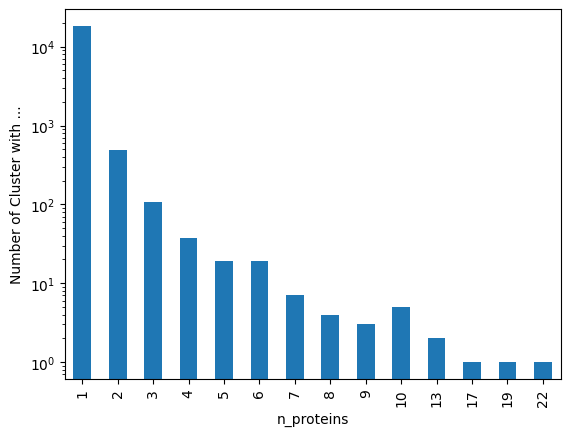

In [19]:
# create a df with clusters as entry
uniref_df = uniref_df.groupby('UniRef50_Cluster').agg({
    'protein': list,
    'gene': list,
}).reset_index()

# count
uniref_df["n_proteins"] = uniref_df.protein.apply(len)
uniref_df["n_genes"] = uniref_df.gene.apply(len)
uniref_df.sort_values(by="n_proteins", inplace=True, ascending=False)

# plot
display(uniref_df)
uniref_df.n_proteins.value_counts().sort_index().plot(kind="bar", logy=True, ylabel="Number of Cluster with ...")

In [20]:
# CHECK: genes or proteins shared acorss clusters

# explode the lists into one row per (cluster, protein)
protein_cluster_map = uniref_df.explode("protein")[["UniRef50_Cluster", "protein"]].dropna()
gene_cluster_map = uniref_df.explode("gene")[["UniRef50_Cluster", "gene"]].dropna()

# group by protein and collect all clusters that contain it
protein_to_clusters = protein_cluster_map.groupby("protein")["UniRef50_Cluster"].unique()
gene_to_clusters = gene_cluster_map.groupby("gene")["UniRef50_Cluster"].unique()

# keep only proteins that occur in >1 cluster
shared_proteins = protein_to_clusters[protein_to_clusters.apply(len) > 1]
shared_genes = gene_to_clusters[gene_to_clusters.apply(len) > 1]

print(f"{len(shared_proteins)} proteins are shared between clusters")
#display(shared_proteins.head())
print(f"{len(shared_genes)} genes are shared between clusters")
#display(shared_genes.head())


0 proteins are shared between clusters
0 genes are shared between clusters


## Mark positive genes and clusters

In [21]:
# Add the 'label' column: 'positive' if at least one protein maps to a positive gene, otherwise 'negative'
uniref_df["cluster_label"] = uniref_df["gene"].apply(
    lambda gene_list: "positive" 
    if any(g in positive_genes for g in gene_list)
    else "negative"
)

# plot how many postive genesets
print(uniref_df["cluster_label"].value_counts())#.sort_index().plot(kind="bar", logy=True,)

#########

# create list of genes AND CORREPSONDET prots that are postive (from above)

# unzip in parallel pritens_clened and genes_clened and create ritens_clened_psotive and genes_clened_positive 
    # maintain if proteins comes form psotive gene
uniref_df["proteins_positive"], uniref_df["genes_positive"] = zip(*uniref_df.apply(
    lambda row: (
        [p for p, g in zip(row["protein"], row["gene"]) if g in positive_genes],
        [g for g in row["gene"] if g in positive_genes]
    ),
    axis=1
))
uniref_df["n_genes_positive"] = uniref_df["genes_positive"].apply(len)
uniref_df.sort_values(by="n_genes_positive", ascending=False, inplace=True)

display(uniref_df.head(5))
display(uniref_df.shape)
uniref_df.n_genes_positive.value_counts().plot(kind="bar", logy=True)

cluster_label
negative    18604
positive      383
Name: count, dtype: int64


UniRef50_Cluster                   protein                      gene  \
3447  UniRef50_P0DP23  [P0DP23, P0DP24, P0DP25]     [CALM1, CALM2, CALM3]   
3432  UniRef50_P0DMV8  [P0DMV8, P0DMV9, P34931]  [HSPA1A, HSPA1B, HSPA1L]   
986   UniRef50_O00139          [O00139, Q99661]            [KIF2A, KIF2C]   
9793  UniRef50_Q6PGQ7                  [Q6PGQ7]                    [BORA]   
7354  UniRef50_Q14186                  [Q14186]                   [TFDP1]   

      n_proteins  n_genes cluster_label         proteins_positive  \
3447           3        3      positive  [P0DP23, P0DP24, P0DP25]   
3432           3        3      positive          [P0DMV8, P0DMV9]   
986            2        2      positive          [O00139, Q99661]   
9793           1        1      positive                  [Q6PGQ7]   
7354           1        1      positive                  [Q14186]   

             genes_positive  n_genes_positive  
3447  [CALM1, CALM2, CALM3]                 3  
3432       [HSPA1A, HSPA1B]                 2  
986          [KIF2A, KIF2C]                 2  
9793                 [BORA]                 1  
7354                [TFDP1]                 1

(18987, 9)

<Axes: xlabel='n_genes_positive'>

## Give probs to positive genes

In [22]:
# give probablities to be samped to each protein
uniref_df["logits"] = uniref_df["genes_positive"].apply(
    lambda gene_list: [positive_gene_freq_map.get(g, 0) for g in gene_list]
)
def safe_softmax(logits):
    if len(logits) == 0:
        return []  # return empty list if no logits
    return softmax(logits).tolist()  # convert numpy array to list
uniref_df["probs"] = uniref_df["logits"].apply(safe_softmax)

uniref_df.head(2)

UniRef50_Cluster                   protein                      gene  \
3447  UniRef50_P0DP23  [P0DP23, P0DP24, P0DP25]     [CALM1, CALM2, CALM3]   
3432  UniRef50_P0DMV8  [P0DMV8, P0DMV9, P34931]  [HSPA1A, HSPA1B, HSPA1L]   

      n_proteins  n_genes cluster_label         proteins_positive  \
3447           3        3      positive  [P0DP23, P0DP24, P0DP25]   
3432           3        3      positive          [P0DMV8, P0DMV9]   

             genes_positive  n_genes_positive      logits  \
3447  [CALM1, CALM2, CALM3]                 3  [9, 11, 9]   
3432       [HSPA1A, HSPA1B]                 2    [14, 14]   

                                                  probs  
3447  [0.10650697891920073, 0.7869860421615984, 0.10...  
3432                                         [0.5, 0.5]

## Create lists of NEGATIVE genes within i can sample

Negative genes are too many.

We need a subsampling before sample them for the final df.
We need to subsample in differt ways:

- lets have nice lenghts: too long, too short
- they cant be positive genes
- they cant be ambiguos genes
- many proteins of same class but still differt (ex. odoranr receptros)
    - SOLUTION: solve wht pfam and interpro domains --> group proteins that have same domains --> take only one from the group


Other ideas if necessary:
- cluster proteins using uniT5 embs and take a protien for each cluster
- proteins still 90% similairty, need to remove reduntat seqeunces?
    - --> impossible, clusters are dissimailr by 50%

### *) Read Domains df

In [23]:
interpro_df = pd.read_csv(config["data_paths"]["interprot_domains"], sep="\t")

def extract_ids(cell, prefix):
    if pd.isna(cell):
        return []
    # Find all matches like PFxxxxx or IPRxxxxx
    ids = re.findall(rf"{prefix}\d+", cell)
    return list(set(ids))  # optional: remove duplicates

# Apply parsing
interpro_df["Pfam_list"] = interpro_df["Pfam"].apply(lambda x: extract_ids(str(x), "PF"))
interpro_df["InterPro_list"] = interpro_df["InterPro"].apply(lambda x: extract_ids(str(x), "IPR"))

interpro_df["n_Pfam"] = interpro_df["Pfam_list"].apply(len)
interpro_df["n_InterPro"] = interpro_df["InterPro_list"].apply(len)

interpro_df["all_domains"] = interpro_df.apply(lambda row: set(row['Pfam_list']) | set(row['InterPro_list']), axis=1)

interpro_df

Entry  Length                   Pfam  \
0      A0A087X1C5     515     PF00067; p450; 2.;   
1      A0A0B4J2F0      54  PF23670; PIGBOS1; 1.;   
2      A0A0C5B5G6      16  PF21945; MT-RNR1; 1.;   
3      A0A0K2S4Q6     201    PF07686; V-set; 1.;   
4      A0A0U1RRE5      68   PF21949; NoBody; 1.;   
...           ...     ...                    ...   
20415      Q9UI25      63                    NaN   
20416      Q9UI54      55                    NaN   
20417      Q9UI72      69                    NaN   
20418      Q9Y3F1      56     PF15789; Hyr1; 1.;   
20419      Q9Y6C7      94                    NaN   

                                                InterPro  Pfam_list  \
0      IPR001128; Cyt_P450.;"IPR017972; Cyt_P450_CS."...  [PF00067]   
1                                                    NaN  [PF23670]   
2                                   IPR054130; MT-RNR1.;  [PF21945]   
3      IPR050671; CD300_family_receptors.;"IPR007110;...  [PF07686]   
4                                    IPR047852; NoBody.;  [PF21949]   
...                                                  ...        ...   
20415                                                NaN         []   
20416                                                NaN         []   
20417                                                NaN         []   
20418                         IPR031573; Cell_wall_rpt.;  [PF15789]   
20419                                                NaN         []   

                                           InterPro_list  n_Pfam  n_InterPro  \
0      [IPR050182, IPR002401, IPR008069, IPR017972, I...       1           6   
1                                                     []       1           0   
2                                            [IPR054130]       1           1   
3      [IPR036179, IPR013783, IPR007110, IPR050671, I...       1           6   
4                                            [IPR047852]       1           1   
...                                                  ...     ...         ...   
20415                                                 []       0           0   
20416                                                 []       0           0   
20417                                                 []       0           0   
20418                                        [IPR031573]       1           1   
20419                                                 []       0           0   

                                             all_domains  
0      {PF00067, IPR008069, IPR017972, IPR036396, IPR...  
1                                              {PF23670}  
2                                   {PF21945, IPR054130}  
3      {IPR013783, IPR007110, IPR050671, IPR003599, I...  
4                                   {IPR047852, PF21949}  
...                                                  ...  
20415                                                 {}  
20416                                                 {}  
20417                                                 {}  
20418                               {PF15789, IPR031573}  
20419                                                 {}  

[20420 rows x 9 columns]

### *) Create df gene-prot to define negative prots

Attch col to say if the protsin is ok based on taht criterion

In [24]:
# Create lists to store protein-gene pairs
proteins_list = []
genes_list = []

# Iterate through each row and expand the lists
for _, row in uniref_df.iterrows():
    proteins = row['protein']
    genes = row['gene']
    
    # Add each protein-gene pair
    for protein, gene in zip(proteins, genes):
        proteins_list.append(protein)
        genes_list.append(gene)

# Create new dataframe with unique pairs
putative_negative_protein_gene_df = pd.DataFrame({
    'protein': proteins_list,
    'gene': genes_list
})#.drop_duplicates() # no duplicates thnaks tot he previous steps

putative_negative_protein_gene_df = pd.merge(how="left", left=putative_negative_protein_gene_df, right=interpro_df[["Entry", "Length"]], left_on="protein", right_on="Entry").drop(columns=["Entry"])

display(putative_negative_protein_gene_df)

protein       gene  Length
0      P0DP23      CALM1     149
1      P0DP24      CALM2     149
2      P0DP25      CALM3     149
3      P0DMV8     HSPA1A     641
4      P0DMV9     HSPA1B     641
...       ...        ...     ...
20179  Q9Y442  YWHAH-AS1     160
20180  Q9Y446       PKP3     797
20181  Q9Y450      HBS1L     684
20182  Q9Y458      TBX22     520
20183  Q9Y2D2    SLC35A3     325

[20184 rows x 3 columns]

### Filter by Length

In [26]:
putative_negative_protein_gene_df = putative_negative_protein_gene_df[
    (putative_negative_protein_gene_df.Length >= config["dataset_creation"]["min_length_negative_protein"]) &
    (putative_negative_protein_gene_df.Length <= config["dataset_creation"]["max_length_negative_protein"]) 
]
putative_negative_protein_gene_df

protein       gene  Length
0      P0DP23      CALM1     149
1      P0DP24      CALM2     149
2      P0DP25      CALM3     149
3      P0DMV8     HSPA1A     641
4      P0DMV9     HSPA1B     641
...       ...        ...     ...
20179  Q9Y442  YWHAH-AS1     160
20180  Q9Y446       PKP3     797
20181  Q9Y450      HBS1L     684
20182  Q9Y458      TBX22     520
20183  Q9Y2D2    SLC35A3     325

[17081 rows x 3 columns]

### Filter by Positive/Ambiguos

In [27]:
putative_negative_protein_gene_df = putative_negative_protein_gene_df[
    (~ putative_negative_protein_gene_df.gene.isin(ambiguos_genes)) &
    (~ putative_negative_protein_gene_df.gene.isin(positive_genes)) 
]
putative_negative_protein_gene_df

protein       gene  Length
148    Q8IYD1      GSPT2     628
400    O43852       CALU     315
402    O00204    SULT2B1     365
404    O00194     RAB27B     218
409    O00217     NDUFS8     210
...       ...        ...     ...
20177  Q9Y421     FAM32A     112
20178  Q9Y426      C2CD2     696
20179  Q9Y442  YWHAH-AS1     160
20182  Q9Y458      TBX22     520
20183  Q9Y2D2    SLC35A3     325

[11054 rows x 3 columns]

### Remove duplicated protein domains

In [28]:
# Filter to current subset of prots
interpro_df = interpro_df[interpro_df.Entry.isin(putative_negative_protein_gene_df.protein.to_list())]

# Convert sets to frozensets for grouping (sets aren't hashable)
interpro_df['domains_hashable'] = interpro_df['all_domains'].apply(frozenset)

# Group by domains and aggregate
final_groups_df = (
    interpro_df[interpro_df.duplicated(subset=['domains_hashable'], keep=False)] #keep=False, mark all pccurencies
    .groupby('domains_hashable')['Entry']  # group by set of domains
    .agg(Proteins_in_Group=list, Group_Size='size')
        #Collect all the protein_id values in the group into a list
        #'size'	Count how many items are in the group
    .reset_index()
    .sort_values('Group_Size', ascending=False)
)

# Convert frozensets back to sets for display
final_groups_df['all_domains'] = final_groups_df['domains_hashable'].apply(set)
final_groups_df = final_groups_df.drop(columns=['domains_hashable'])

display(final_groups_df)

# Clean up the temporary column
interpro_df = interpro_df.drop(columns=['domains_hashable'])
interpro_df = interpro_df.drop_duplicates(subset="all_domains")

# Filter df
putative_negative_protein_gene_df = putative_negative_protein_gene_df[putative_negative_protein_gene_df.protein.isin(interpro_df.Entry.to_list())]

print("Remained proteins:", len(putative_negative_protein_gene_df))

/tmp/ipykernel_16305/2307221464.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interpro_df['domains_hashable'] = interpro_df['all_domains'].apply(frozenset)


Proteins_in_Group  Group_Size  \
0     [P26371, P40205, P60329, Q2M2E3, Q5SWW7, Q66K8...         329   
1002  [O43749, P34982, Q8NG98, Q8NHC4, Q96KK4, A4D2G...         245   
765   [O94892, P17021, P52736, P52742, Q16587, Q3KNS...          90   
869   [P01593, P01594, P01597, P01602, P01619, P0169...          65   
578   [Q9H255, A6NGY5, Q8NGH7, Q8NGI2, Q8NGK2, Q8NH5...          58   
...                                                 ...         ...   
21                                     [Q8NC01, Q9P126]           2   
20                                     [Q8NBN3, Q96K49]           2   
19                                     [Q8N3C7, Q96DZ5]           2   
1441                                   [P31150, P50395]           2   
1423                                   [P30968, Q96P88]           2   

                                            all_domains  
0                                                    {}  
1002         {IPR000276, IPR017452, IPR000725, PF13853}  
765   {IPR036051, IPR013087, PF01352, IPR036236, IPR...  
869   {IPR013783, IPR050150, IPR007110, IPR003599, I...  
578   {IPR017452, PF13853, IPR050402, IPR000276, IPR...  
...                                                 ...  
21    {IPR033992, IPR016187, PF00059, IPR001304, IPR...  
20    {IPR009637, IPR053937, PF21901, PF06814, IPR05...  
19    {IPR036770, PF12796, PF01302, IPR002110, IPR00...  
1441         {IPR000806, IPR036188, PF00996, IPR018203}  
1423         {PF00001, IPR000276, IPR017452, IPR001658}  

[1445 rows x 3 columns]

Remained proteins: 6730


# Optional: subsample to remove proteins with overlapping domains

In [30]:
# Convert domain sets to lists
domain_lists = interpro_df['all_domains'].apply(list)

# Create binary matrix: proteins x domains
mlb = MultiLabelBinarizer()
binary_matrix = mlb.fit_transform(domain_lists)

# Calculate Jaccard similarity
# Jaccard = intersection / union
X = binary_matrix.astype(float)
intersection = X @ X.T #intersection counts (like AND)
union = X.sum(axis=1).reshape(-1, 1) + X.sum(axis=1) - intersection #sum of each row pair minus their intersection
jaccard_matrix = intersection / union

# Convert to DataFrame
jaccard_df = pd.DataFrame(
    jaccard_matrix, 
    index=interpro_df['Entry'], 
    columns=interpro_df['Entry']
)

print(f"Shape: {binary_matrix.shape} (proteins x domains)")
print(f"\nJaccard similarity matrix:")
display(jaccard_df)

Shape: (6730, 15101) (proteins x domains)

Jaccard similarity matrix:


/tmp/ipykernel_16305/2586831039.py:13: RuntimeWarning: invalid value encountered in divide
  jaccard_matrix = intersection / union


Entry       A0A087X1C5  A0A0K2S4Q6  A0A1B0GTW7  A0AV02  A0AV96  A0AVF1  \
Entry                                                                    
A0A087X1C5         1.0         0.0         0.0     0.0     0.0     0.0   
A0A0K2S4Q6         0.0         1.0         0.0     0.0     0.0     0.0   
A0A1B0GTW7         0.0         0.0         1.0     0.0     0.0     0.0   
A0AV02             0.0         0.0         0.0     1.0     0.0     0.0   
A0AV96             0.0         0.0         0.0     0.0     1.0     0.0   
...                ...         ...         ...     ...     ...     ...   
Q8WZ69             0.0         0.0         0.0     0.0     0.0     0.0   
Q96BT1             0.0         0.0         0.0     0.0     0.0     0.0   
Q96KX1             0.0         0.0         0.0     0.0     0.0     0.0   
Q96PS1             0.0         0.0         0.0     0.0     0.0     0.0   
Q9H693             0.0         0.0         0.0     0.0     0.0     0.0   

Entry       A0FGR9  A0JP26    A0M8Q6  A0PJK1  ...  Q6UXQ4  Q6ZMV7  Q6ZR85  \
Entry                                         ...                           
A0A087X1C5     0.0     0.0  0.000000     0.0  ...     0.0     0.0     0.0   
A0A0K2S4Q6     0.0     0.0  0.272727     0.0  ...     0.0     0.0     0.0   
A0A1B0GTW7     0.0     0.0  0.000000     0.0  ...     0.0     0.0     0.0   
A0AV02         0.0     0.0  0.000000     0.0  ...     0.0     0.0     0.0   
A0AV96         0.0     0.0  0.000000     0.0  ...     0.0     0.0     0.0   
...            ...     ...       ...     ...  ...     ...     ...     ...   
Q8WZ69         0.0     0.0  0.000000     0.0  ...     0.0     0.0     0.0   
Q96BT1         0.0     0.0  0.000000     0.0  ...     0.0     0.0     0.0   
Q96KX1         0.0     0.0  0.000000     0.0  ...     0.0     0.0     0.0   
Q96PS1         0.0     0.0  0.000000     0.0  ...     0.0     0.0     0.0   
Q9H693         0.0     0.0  0.000000     0.0  ...     0.0     0.0     0.0   

Entry       Q8N8J0  Q8WU49  Q8WZ69  Q96BT1  Q96KX1  Q96PS1  Q9H693  
Entry                                                               
A0A087X1C5     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
A0A0K2S4Q6     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
A0A1B0GTW7     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
A0AV02         0.0     0.0     0.0     0.0     0.0     0.0     0.0  
A0AV96         0.0     0.0     0.0     0.0     0.0     0.0     0.0  
...            ...     ...     ...     ...     ...     ...     ...  
Q8WZ69         0.0     0.0     1.0     0.0     0.0     0.0     0.0  
Q96BT1         0.0     0.0     0.0     1.0     0.0     0.0     0.0  
Q96KX1         0.0     0.0     0.0     0.0     1.0     0.0     0.0  
Q96PS1         0.0     0.0     0.0     0.0     0.0     1.0     0.0  
Q9H693         0.0     0.0     0.0     0.0     0.0     0.0     1.0  

[6730 rows x 6730 columns]

Jaccard Similarity Statistics:
Min: 0.0189
Max: 0.9474
Mean: 0.2204
Median: 0.1579
Std: 0.1767


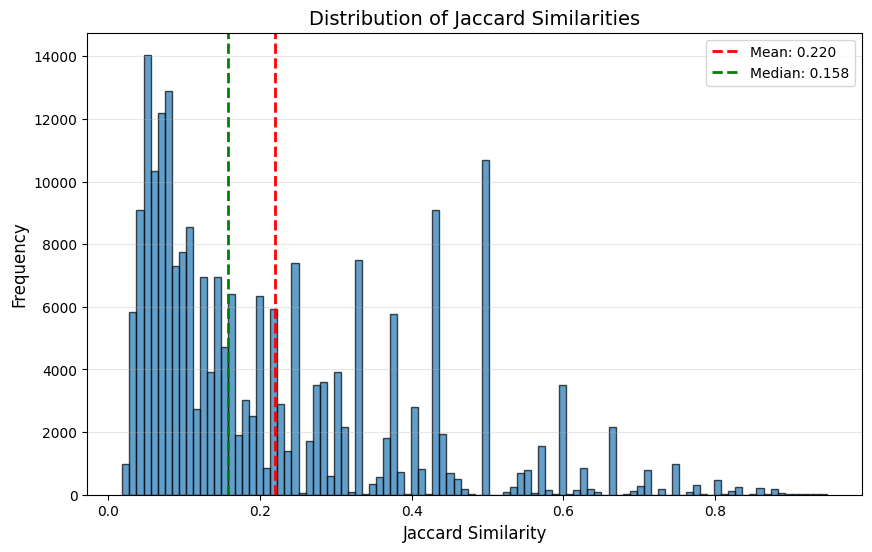

In [41]:
# Flatten the Jaccard matrix (exclude diagonal if it's 1.0 self-similarity)
jaccard_values = jaccard_matrix[np.triu_indices_from(jaccard_matrix, k=1)]  # Upper triangle only
jaccard_values = jaccard_values[jaccard_values != 0]

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(jaccard_values, bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('Jaccard Similarity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Jaccard Similarities', fontsize=14)
plt.grid(axis='y', alpha=0.3)

# Add statistics
mean_val = np.mean(jaccard_values)
median_val = np.median(jaccard_values)
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.3f}')
plt.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.3f}')
plt.legend()

# Print summary statistics
print("Jaccard Similarity Statistics:")
print(f"Min: {jaccard_values.min():.4f}")
print(f"Max: {jaccard_values.max():.4f}")
print(f"Mean: {mean_val:.4f}")
print(f"Median: {median_val:.4f}")
print(f"Std: {np.std(jaccard_values):.4f}")

In [52]:
# Create edge list using SIMILARITY (Jaccard) as weights
# Leiden with ModularityVertexPartition: higher weight = stronger connection
threshold = median_val  # Minimum Jaccard similarity to create an edge

edges = []
weights = []
for i in range(len(jaccard_df)):
    for j in range(i+1, len(jaccard_df)):
        similarity = jaccard_matrix[i, j]
        if similarity > threshold:  # Use similarity directly
            edges.append((i, j))
            weights.append(similarity)  # Higher Jaccard = stronger edge

# Create igraph
g = ig.Graph(n=len(jaccard_df), edges=edges)
g.es['weight'] = weights

# Run Leiden clustering
partition = leidenalg.find_partition(
    g, 
    leidenalg.ModularityVertexPartition,
    weights='weight',
    n_iterations=-1,  # Run until convergence
    seed=42 
)

# Add cluster labels to dataframe
interpro_df['Leiden_Cluster'] = partition.membership

for i, g in interpro_df.groupby(['Leiden_Cluster']):
    print("Cluster name", i, "Lenght:", len(g))
    display("Memebers:", g.Entry.unique())
    if i[0] == 0:
        break

print(f"\nNumber of clusters: {len(set(partition.membership))}")
print(f"Modularity: {partition.modularity:.3f}")
print(f"\nCluster sizes:")
display(interpro_df['Leiden_Cluster'].value_counts().sort_index())

# Check for singletons (clusters with only 1 member)
cluster_sizes = interpro_df['Leiden_Cluster'].value_counts()
singletons = cluster_sizes[cluster_sizes == 1]
print(f"\nSingletons (clusters of size 1): {len(singletons)}")

Cluster name (0,) Lenght: 373


'Memebers:'

array(['A0FGR9', 'A1X283', 'A6NK89', 'O00233', 'O00308', 'O00429',
       'O00445', 'O00459', 'O14492', 'O14512', 'O14523', 'O14526',
       'O14543', 'O14544', 'O14796', 'O14910', 'O14936', 'O14939',
       'O15033', 'O15117', 'O15211', 'O15259', 'O15327', 'O15484',
       'O15524', 'O43281', 'O43374', 'O43559', 'O43581', 'O43586',
       'O60313', 'O60447', 'O60493', 'O60504', 'O60749', 'O60759',
       'O60861', 'O75052', 'O75112', 'O75159', 'O75553', 'O75886',
       'O94868', 'O94989', 'O95140', 'O95294', 'O95398', 'O95704',
       'O95741', 'O96018', 'P08567', 'P0C869', 'P10911', 'P14222',
       'P14317', 'P14598', 'P15259', 'P15498', 'P15882', 'P22059',
       'P42331', 'P46109', 'P46937', 'P47712', 'P49675', 'P50479',
       'P50749', 'P51178', 'P52735', 'P53367', 'P54105', 'P54284',
       'P57075', 'P57105', 'P57768', 'P60981', 'P62993', 'P78314',
       'P78352', 'P98077', 'P98174', 'Q01968', 'Q02641', 'Q05084',
       'Q07960', 'Q08289', 'Q0JRZ9', 'Q0VAM2', 'Q12792', 'Q129


Number of clusters: 2108
Modularity: 0.835

Cluster sizes:


Leiden_Cluster
0       373
1       321
2       260
3       221
4       216
       ... 
2103      1
2104      1
2105      1
2106      1
2107      1
Name: count, Length: 2108, dtype: int64


Singletons (clusters of size 1): 1693


In [53]:
# retain onlyu one prot form each cluster
interpro_df_filtered = interpro_df.drop_duplicates(subset=["Leiden_Cluster"]).copy()
display(interpro_df_filtered)

# Filter df
putative_negative_protein_gene_df = putative_negative_protein_gene_df[putative_negative_protein_gene_df.protein.isin(interpro_df_filtered.Entry.to_list())]
display(putative_negative_protein_gene_df)


Entry  Length                        Pfam  \
0      A0A087X1C5     515          PF00067; p450; 2.;   
3      A0A0K2S4Q6     201         PF07686; V-set; 1.;   
5      A0A1B0GTW7     788  PF01457; Peptidase_M8; 1.;   
6          A0AV02     714   PF00324; AA_permease; 1.;   
7          A0AV96     593         PF00076; RRM_1; 3.;   
...           ...     ...                         ...   
20362      Q8WZ69     217       PF17706; DUF5552; 1.;   
20364      Q96BT1     292                         NaN   
20369      Q96KX1     117       PF15022; DUF4522; 1.;   
20383      Q96PS1     177      PF15124; FANCD2OS; 1.;   
20402      Q9H693     158       PF15132; DUF4568; 1.;   

                                                InterPro  Pfam_list  \
0      IPR001128; Cyt_P450.;"IPR017972; Cyt_P450_CS."...  [PF00067]   
3      IPR050671; CD300_family_receptors.;"IPR007110;...  [PF07686]   
5                              IPR001577; Peptidase_M8.;  [PF01457]   
6      IPR004841; AA-permease/SLC12A_dom.;"IPR004842;...  [PF00324]   
7      IPR006535; HnRNP_R/Q_splicing_fac.;"IPR012677;...  [PF00076]   
...                                                  ...        ...   
20362                               IPR041435; DUF5552.;  [PF17706]   
20364                          IPR055322; C3orf49-like.;         []   
20369                               IPR027825; DUF4522.;  [PF15022]   
20383                              IPR027966; FANCD2OS.;  [PF15124]   
20402                               IPR027919; DUF4568.;  [PF15132]   

                                           InterPro_list  n_Pfam  n_InterPro  \
0      [IPR050182, IPR002401, IPR008069, IPR017972, I...       1           6   
3      [IPR036179, IPR013783, IPR007110, IPR050671, I...       1           6   
5                                            [IPR001577]       1           1   
6                                 [IPR004841, IPR004842]       1           2   
7      [IPR047044, IPR034445, IPR000504, IPR035979, I...       1           7   
...                                                  ...     ...         ...   
20362                                        [IPR041435]       1           1   
20364                                        [IPR055322]       0           1   
20369                                        [IPR027825]       1           1   
20383                                        [IPR027966]       1           1   
20402                                        [IPR027919]       1           1   

                                             all_domains  Leiden_Cluster  
0      {PF00067, IPR008069, IPR017972, IPR036396, IPR...              36  
3      {IPR013783, IPR007110, IPR050671, IPR003599, I...               2  
5                                   {PF01457, IPR001577}             415  
6                        {PF00324, IPR004841, IPR004842}             416  
7      {PF00076, IPR047044, IPR034445, IPR000504, IPR...              12  
...                                                  ...             ...  
20362                               {IPR041435, PF17706}            2103  
20364                                        {IPR055322}            2104  
20369                               {IPR027825, PF15022}            2105  
20383                               {PF15124, IPR027966}            2106  
20402                               {PF15132, IPR027919}            2107  

[2108 rows x 10 columns]

protein     gene  Length
409    O00217   NDUFS8     210
416    O43837    IDH3B     385
422    O00273     DFFA     331
432    O00422    SAP18     153
434    O00418    EEF2K     725
...       ...      ...     ...
20083  Q9Y2Z2     MTO1     717
20114  Q9Y2G5   POFUT2     429
20125  Q9Y2B2     PIGL     252
20126  Q9Y2B4  TP53TG5     290
20177  Q9Y421   FAM32A     112

[2108 rows x 3 columns]

### Prepare col where to sample negatives

In [54]:
# Create list of putative negative genes/protein        
    # ATTENTION; putatove = neither postive neither ambigous
uniref_df["putative_negative_proteins"], uniref_df["putative_negative_genes"] = zip(*uniref_df.apply(
    lambda row: (
        [p for p, g in zip(row["protein"], row["gene"]) if p in putative_negative_protein_gene_df.protein.to_list()],
        [g for p, g in zip(row["protein"], row["gene"]) if p in putative_negative_protein_gene_df.protein.to_list()],
    ),
    axis=1
))
# count
uniref_df["n_putative_negative_genes"] = uniref_df.putative_negative_genes.apply(len)

# ATTENTION: same NEGATIVE clusters coudl have 0 proteins
# necause all proteins are postive OR ambigous so nothing left to sample as negative)

display(uniref_df.head(5))


UniRef50_Cluster                   protein                      gene  \
3447  UniRef50_P0DP23  [P0DP23, P0DP24, P0DP25]     [CALM1, CALM2, CALM3]   
3432  UniRef50_P0DMV8  [P0DMV8, P0DMV9, P34931]  [HSPA1A, HSPA1B, HSPA1L]   
986   UniRef50_O00139          [O00139, Q99661]            [KIF2A, KIF2C]   
9793  UniRef50_Q6PGQ7                  [Q6PGQ7]                    [BORA]   
7354  UniRef50_Q14186                  [Q14186]                   [TFDP1]   

      n_proteins  n_genes cluster_label         proteins_positive  \
3447           3        3      positive  [P0DP23, P0DP24, P0DP25]   
3432           3        3      positive          [P0DMV8, P0DMV9]   
986            2        2      positive          [O00139, Q99661]   
9793           1        1      positive                  [Q6PGQ7]   
7354           1        1      positive                  [Q14186]   

             genes_positive  n_genes_positive      logits  \
3447  [CALM1, CALM2, CALM3]                 3  [9, 11, 9]   
3432       [HSPA1A, HSPA1B]                 2    [14, 14]   
986          [KIF2A, KIF2C]                 2    [17, 31]   
9793                 [BORA]                 1        [23]   
7354                [TFDP1]                 1        [42]   

                                                  probs  \
3447  [0.10650697891920073, 0.7869860421615984, 0.10...   
3432                                         [0.5, 0.5]   
986         [8.315280276641321e-07, 0.9999991684719722]   
9793                                              [1.0]   
7354                                              [1.0]   

     putative_negative_proteins putative_negative_genes  \
3447                         []                      []   
3432                         []                      []   
986                          []                      []   
9793                         []                      []   
7354                         []                      []   

      n_putative_negative_genes  
3447                          0  
3432                          0  
986                           0  
9793                          0  
7354                          0

# *) Are there enriched clusters?

fraction_positive
0.000000    18604
0.333333        1
0.500000        8
0.666667        1
1.000000      373
Name: count, dtype: int64


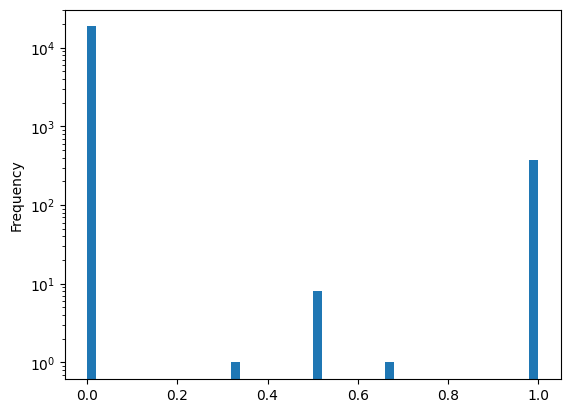

In [55]:
# FRACTION OF CLUSTER OCCUPIED BY POSITIVE GENES
uniref_df["fraction_positive"] = uniref_df.n_genes_positive / uniref_df.n_genes
uniref_df.sort_values(by="fraction_positive", inplace=True, ascending=False)

# hsit
uniref_df.fraction_positive.plot(kind="hist", logy=True, bins=50)
print(uniref_df.fraction_positive.value_counts().sort_index())


In [56]:
# HYPERGEMOETRIC TEST

# Filter genesets with enough genes
    # ATTENTION
    # CANNOT USE TOO SMALL DRAWING (n) --> test power comes from the changing probabilities over several draws, known as sampling without replacemen
uniref_df_big = uniref_df[uniref_df.n_genes >= 1].copy()

# Define background
total_genes = len(set().union(*uniref_df_big["gene"]))
total_positive = len(set().union(*uniref_df_big["genes_positive"]))
print(f"Unique total genes: {total_genes}")
print(f"Unique total positive genes: {total_positive}")

# Run enrichment test
results = uniref_df_big.apply(
    lambda row: pd.Series(
        dataf.per_cluster_hypergeom_test(
            row["n_genes"], 
            row["n_genes_positive"], 
            total_genes, 
            total_positive
        )
    ), 
    axis=1
)
results.columns = ["enrichment_prob", "enrichment_pvalue"]

# Combine results
df_uniref_enriched = pd.concat([uniref_df_big, results], axis=1)
df_uniref_enriched = df_uniref_enriched.sort_values("enrichment_pvalue")

# Multiple testing correction (FDR)
df_uniref_enriched["enrichment_pvalue_adj"] = multipletests(
    df_uniref_enriched["enrichment_pvalue"], 
    method="fdr_bh"
)[1]
df_uniref_enriched["significant"] = df_uniref_enriched["enrichment_pvalue_adj"] < 0.05

# Summary
print(f"\nSignificant enriched gene sets: {df_uniref_enriched['significant'].sum()} / {len(df_uniref_enriched)}")
display(
    df_uniref_enriched[
        ["UniRef50_Cluster", "n_genes", "n_genes_positive", 
         "enrichment_prob", "enrichment_pvalue", 
         "enrichment_pvalue_adj", "significant"]
    ].head(10)
)

# only enriched
df_uniref_significant = df_uniref_enriched[df_uniref_enriched['significant'] == True]

Unique total genes: 20184
Unique total positive genes: 387

Significant enriched gene sets: 0 / 18987


UniRef50_Cluster  n_genes  n_genes_positive  enrichment_prob  \
3447   UniRef50_P0DP23        3                 3         0.000007   
986    UniRef50_O00139        2                 2         0.000367   
3432   UniRef50_P0DMV8        3                 2         0.001079   
9790   UniRef50_Q6PGN9        1                 1         0.019174   
16613  UniRef50_Q9HD47        1                 1         0.019174   
3027   UniRef50_P05556        1                 1         0.019174   
7354   UniRef50_Q14186        1                 1         0.019174   
2968   UniRef50_P04818        1                 1         0.019174   
7561   UniRef50_Q15003        1                 1         0.019174   
7467   UniRef50_Q14683        1                 1         0.019174   

       enrichment_pvalue  enrichment_pvalue_adj  significant  
3447            0.000007               0.132818        False  
986             0.000367               0.973394        False  
3432            0.001086               0.973394        False  
9790            0.019174               0.973394        False  
16613           0.019174               0.973394        False  
3027            0.019174               0.973394        False  
7354            0.019174               0.973394        False  
2968            0.019174               0.973394        False  
7561            0.019174               0.973394        False  
7467            0.019174               0.973394        False

# Create Dataset

## Positive class sampling

In [57]:
# Filter only positive clusters
uniref_df_pos = uniref_df[uniref_df.cluster_label == "positive"].copy()

# sample or take all postive proteins?
if not config["dataset_creation"]["sample_positive_genes"]:
    SAMPLE_N_POSITIVE = uniref_df_pos.n_genes_positive.max() # the number to sample is the max possbile
else:
    SAMPLE_N_POSITIVE = config["dataset_creation"]["number_positive_genes_to_sample_per_cluster"]

uniref_df_pos["proteins_sampled"], uniref_df_pos["genes_sampled"] = zip(
    *uniref_df_pos.apply(
            dataf.sample_sampled_from_single_row, 
            axis=1, 
            min_sample_n=SAMPLE_N_POSITIVE, 
            gene_col="genes_positive",  # ATTENTION_: sample from correct columns
            prot_col="proteins_positive", 
            probs_col="probs")
)
uniref_df_pos["n_proteins_sampled"] = uniref_df_pos.proteins_sampled.apply(len)

display(uniref_df_pos.head(2))
print(uniref_df_pos.shape)

UniRef50_Cluster   protein     gene  n_proteins  n_genes cluster_label  \
13673  UniRef50_Q969U6  [Q969U6]  [FBXW5]           1        1      positive   
4409   UniRef50_P26583  [P26583]  [HMGB2]           1        1      positive   

      proteins_positive genes_positive  n_genes_positive logits  probs  \
13673          [Q969U6]        [FBXW5]                 1    [9]  [1.0]   
4409           [P26583]        [HMGB2]                 1   [19]  [1.0]   

      putative_negative_proteins putative_negative_genes  \
13673                         []                      []   
4409                          []                      []   

       n_putative_negative_genes  fraction_positive proteins_sampled  \
13673                          0                1.0         [Q969U6]   
4409                           0                1.0         [P26583]   

      genes_sampled  n_proteins_sampled  
13673       [FBXW5]                   1  
4409        [HMGB2]                   1

(383, 18)


## Negative Sampling

ATTENTION: cannto have portisn from the same cluster split in class psotive and negative

In [ ]:
# Filter only positive clusters
    # sample from clusters that do nto contain psotive (negative label of before)
uniref_df_neg = uniref_df[
    (uniref_df.n_putative_negative_genes > 0) & # some lcuster maybe haev only ambigus genes
    (uniref_df.cluster_label == "negative") # avoid proteins from proteins class are used as eagtive
    ].copy() 

uniref_df_neg["proteins_sampled"], uniref_df_neg["genes_sampled"] = zip(
    *uniref_df_neg.apply(
            dataf.sample_sampled_from_single_row, 
            axis=1, 
            min_sample_n=SAMPLE_N_POSITIVE, 
            gene_col="putative_negative_genes", 
            prot_col="putative_negative_proteins", 
            probs_col=None # uniform
            )
)
uniref_df_neg["n_proteins_sampled"] = uniref_df_neg.proteins_sampled.apply(len)

# ATTENTION: same clusters coudl have 0 proteins to sample from (all proteins are postive OR ambigous so nothing left to sample as negative)
uniref_df_neg = uniref_df_neg[uniref_df_neg.n_proteins_sampled > 0]

display(uniref_df_neg.head())
print(uniref_df_neg.shape)

UniRef50_Cluster                           protein  \
16451  UniRef50_Q9HAW9  [Q9HAW8, Q9HAW7, Q9HAW9, O60656]   
8644   UniRef50_Q5JQC4      [Q5JQC4, P0C2W7, A0A0U1RQG5]   
2480   UniRef50_O95377          [O75712, Q9NTQ9, O95377]   
1246   UniRef50_O14791                  [O14791, Q9BQE5]   
11057  UniRef50_Q86Y29                  [Q86Y30, Q86Y29]   

                                    gene  n_proteins  n_genes cluster_label  \
16451  [UGT1A10, UGT1A7, UGT1A8, UGT1A9]           4        4      negative   
8644            [CT47A1, CT47B1, CT47C1]           3        3      negative   
2480                  [GJB3, GJB4, GJB5]           3        3      negative   
1246                      [APOL1, APOL2]           2        2      negative   
11057                     [BAGE2, BAGE3]           2        2      negative   

      proteins_positive genes_positive  n_genes_positive logits probs  \
16451                []             []                 0     []    []   
8644                 []             []                 0     []    []   
2480                 []             []                 0     []    []   
1246                 []             []                 0     []    []   
11057                []             []                 0     []    []   

      putative_negative_proteins putative_negative_genes  \
16451                   [O60656]                [UGT1A9]   
8644                    [Q5JQC4]                [CT47A1]   
2480                    [O75712]                  [GJB3]   
1246                    [O14791]                 [APOL1]   
11057                   [Q86Y29]                 [BAGE3]   

       n_putative_negative_genes  fraction_positive proteins_sampled  \
16451                          1                0.0         [O60656]   
8644                           1                0.0         [Q5JQC4]   
2480                           1                0.0         [O75712]   
1246                           1                0.0         [O14791]   
11057                          1                0.0         [Q86Y29]   

      genes_sampled  n_proteins_sampled  
16451      [UGT1A9]                   1  
8644       [CT47A1]                   1  
2480         [GJB3]                   1  
1246        [APOL1]                   1  
11057       [BAGE3]                   1

(2108, 18)


## Make dataset

- concat pos and neg
- expand to have

| Cluster | protein name | label | seq |

In [59]:
# add labels
uniref_df_pos["label_single_prot"] = 1
uniref_df_neg["label_single_prot"] = 0

# merge --> each entry is a cluster
dataset_df = pd.concat([uniref_df_pos, uniref_df_neg])
display(dataset_df.head())
display(dataset_df.shape)

UniRef50_Cluster   protein       gene  n_proteins  n_genes  \
13673  UniRef50_Q969U6  [Q969U6]    [FBXW5]           1        1   
4409   UniRef50_P26583  [P26583]    [HMGB2]           1        1   
13859  UniRef50_Q96CS2  [Q96CS2]    [HAUS1]           1        1   
4436   UniRef50_P27448  [P27448]    [MARK3]           1        1   
5153   UniRef50_P46060  [P46060]  [RANGAP1]           1        1   

      cluster_label proteins_positive genes_positive  n_genes_positive logits  \
13673      positive          [Q969U6]        [FBXW5]                 1    [9]   
4409       positive          [P26583]        [HMGB2]                 1   [19]   
13859      positive          [Q96CS2]        [HAUS1]                 1   [14]   
4436       positive          [P27448]        [MARK3]                 1   [13]   
5153       positive          [P46060]      [RANGAP1]                 1   [16]   

       probs putative_negative_proteins putative_negative_genes  \
13673  [1.0]                         []                      []   
4409   [1.0]                         []                      []   
13859  [1.0]                         []                      []   
4436   [1.0]                         []                      []   
5153   [1.0]                         []                      []   

       n_putative_negative_genes  fraction_positive proteins_sampled  \
13673                          0                1.0         [Q969U6]   
4409                           0                1.0         [P26583]   
13859                          0                1.0         [Q96CS2]   
4436                           0                1.0         [P27448]   
5153                           0                1.0         [P46060]   

      genes_sampled  n_proteins_sampled  label_single_prot  
13673       [FBXW5]                   1                  1  
4409        [HMGB2]                   1                  1  
13859       [HAUS1]                   1                  1  
4436        [MARK3]                   1                  1  
5153      [RANGAP1]                   1                  1

(2491, 19)

In [60]:
# Create long df

# smaller df
cols_to_keep = ['UniRef50_Cluster', 'proteins_sampled',
                'genes_sampled', 'label_single_prot']
dataset_df_small = dataset_df[cols_to_keep].copy()
display(dataset_df_small)

# Create a new DataFrame where each row corresponds to a (protein, gene) pair
rows = []
for _, row in dataset_df_small.iterrows():
    cluster = row["UniRef50_Cluster"]
    label = row["label_single_prot"]
    proteins = row["proteins_sampled"]
    genes = row["genes_sampled"]

    # zip ensures 1-to-1 pairing between proteins and genes
    for prot, gene in zip(proteins, genes):
        rows.append({
            "UniRef50_Cluster": cluster,
            "protein": prot,
            "gene": gene,
            "label": label
        })

df_long = pd.DataFrame(rows)

print("ATTENTION: the number of proteins sampled is less than the total ~20000 of Swissport, as we subsampled only N, so we may have lsot some proteins")
print(df_long.protein.nunique(), "/ ~20000")

# checj fro duplcates
print("\nDuplicated rows/proteins: ", df_long.shape[0] - df_long.protein.nunique())

df_long

UniRef50_Cluster proteins_sampled genes_sampled  label_single_prot
13673  UniRef50_Q969U6         [Q969U6]       [FBXW5]                  1
4409   UniRef50_P26583         [P26583]       [HMGB2]                  1
13859  UniRef50_Q96CS2         [Q96CS2]       [HAUS1]                  1
4436   UniRef50_P27448         [P27448]       [MARK3]                  1
5153   UniRef50_P46060         [P46060]     [RANGAP1]                  1
...                ...              ...           ...                ...
6221   UniRef50_P63272         [P63272]     [SUPT4H1]                  0
6590   UniRef50_Q02747         [Q02747]      [GUCA2A]                  0
6642   UniRef50_Q03989         [Q03989]      [ARID5A]                  0
6625   UniRef50_Q03393         [Q03393]         [PTS]                  0
6667   UniRef50_Q04900         [Q04900]       [CD164]                  0

[2491 rows x 4 columns]

ATTENTION: the number of proteins sampled is less than the total ~20000 of Swissport, as we subsampled only N, so we may have lsot some proteins
2495 / ~20000

Duplicated rows/proteins:  0


UniRef50_Cluster protein     gene  label
0     UniRef50_Q969U6  Q969U6    FBXW5      1
1     UniRef50_P26583  P26583    HMGB2      1
2     UniRef50_Q96CS2  Q96CS2    HAUS1      1
3     UniRef50_P27448  P27448    MARK3      1
4     UniRef50_P46060  P46060  RANGAP1      1
...               ...     ...      ...    ...
2490  UniRef50_P63272  P63272  SUPT4H1      0
2491  UniRef50_Q02747  Q02747   GUCA2A      0
2492  UniRef50_Q03989  Q03989   ARID5A      0
2493  UniRef50_Q03393  Q03393      PTS      0
2494  UniRef50_Q04900  Q04900    CD164      0

[2495 rows x 4 columns]

## Assure 1:N ratio in postive:negative class
After previos sampling sampling you will have
- | pos prot | << | neg prot | → more thna 1:3 ration
- Need to subsampled negative class
- Subsample negative class
    - Subsample the remaining cluster to have a final ratio 1:3

In [61]:
# list of smpled positve proteins
positive_proteins_tmp = set(df_long[df_long.label == 1]["protein"].unique())

# list of prtein in MIXED cluster (wiht inside btoh postive and negative prteins)
    # ATTENTUON: check no ptortien in mixed clusters
proteins_in_mixed_clusters = df_long.groupby('UniRef50_Cluster').filter(lambda x: x['label'].nunique() > 1).sort_values(by="UniRef50_Cluster")
print("priteins in mixed clusters:", len(proteins_in_mixed_clusters))
proteins_in_mixed_clusters = set(proteins_in_mixed_clusters["protein"].unique())

# proteins to NOT remove
proteins_not_to_remove = proteins_in_mixed_clusters.union(positive_proteins_tmp)

# give col
df_long["can_be_removed"] = ~df_long["protein"].isin(proteins_not_to_remove)

df_long

priteins in mixed clusters: 0


UniRef50_Cluster protein     gene  label  can_be_removed
0     UniRef50_Q969U6  Q969U6    FBXW5      1           False
1     UniRef50_P26583  P26583    HMGB2      1           False
2     UniRef50_Q96CS2  Q96CS2    HAUS1      1           False
3     UniRef50_P27448  P27448    MARK3      1           False
4     UniRef50_P46060  P46060  RANGAP1      1           False
...               ...     ...      ...    ...             ...
2490  UniRef50_P63272  P63272  SUPT4H1      0            True
2491  UniRef50_Q02747  Q02747   GUCA2A      0            True
2492  UniRef50_Q03989  Q03989   ARID5A      0            True
2493  UniRef50_Q03393  Q03393      PTS      0            True
2494  UniRef50_Q04900  Q04900    CD164      0            True

[2495 rows x 5 columns]

In [62]:
# decide fraction to susample

# Number of positive proteins
n_positive = df_long[df_long["label"] == 1].shape[0]
# Number desidered negative
n_desired_negatives = n_positive * config["dataset_creation"]["mult_factor_negative_class"]
# Removable (negative) proteins
removable_negatives = df_long[(df_long["label"] == 0) & (df_long["can_be_removed"])]
# Determine fraction to subsample
frac_to_sample = n_desired_negatives / len(removable_negatives)
frac_to_sample = min(frac_to_sample, 1.0)  # cannot sample more than available

frac_to_sample

0.5507590132827325

In [63]:
# susample
removable = df_long[df_long["can_be_removed"]]
keep = df_long[~df_long["can_be_removed"]]

subsampled_removable = removable.sample(frac=frac_to_sample)

df_subsampled = pd.concat([keep, subsampled_removable]).reset_index(drop=True) # Combine back with the protected proteins

print(df_subsampled.label.value_counts())
df_subsampled

label
0    1161
1     387
Name: count, dtype: int64


UniRef50_Cluster protein      gene  label  can_be_removed
0     UniRef50_Q969U6  Q969U6     FBXW5      1           False
1     UniRef50_P26583  P26583     HMGB2      1           False
2     UniRef50_Q96CS2  Q96CS2     HAUS1      1           False
3     UniRef50_P27448  P27448     MARK3      1           False
4     UniRef50_P46060  P46060   RANGAP1      1           False
...               ...     ...       ...    ...             ...
1543  UniRef50_P09110  P09110     ACAA1      0            True
1544  UniRef50_Q96AA3  Q96AA3      RFT1      0            True
1545  UniRef50_Q8IVJ1  Q8IVJ1   SLC41A1      0            True
1546  UniRef50_O95402  O95402     MED26      0            True
1547  UniRef50_Q8IUX1  Q8IUX1  TMEM126B      0            True

[1548 rows x 5 columns]

## Give Sequence


In [65]:
### create df to join
join_df_tmp = proteome_uniprot[["Entry", "Sequence"]].copy().rename(columns={"Sequence": "sequence"})

# join
    # ATTNETION: we shoudl NOT lose any col
long_df_seq = pd.merge(how="inner", left=df_subsampled, right=join_df_tmp, left_on="protein", right_on="Entry")

# drp cols
long_df_seq.drop(columns=["Entry"], inplace=True)

long_df_seq

UniRef50_Cluster protein      gene  label  can_be_removed  \
0     UniRef50_Q969U6  Q969U6     FBXW5      1           False   
1     UniRef50_P26583  P26583     HMGB2      1           False   
2     UniRef50_Q96CS2  Q96CS2     HAUS1      1           False   
3     UniRef50_P27448  P27448     MARK3      1           False   
4     UniRef50_P46060  P46060   RANGAP1      1           False   
...               ...     ...       ...    ...             ...   
1543  UniRef50_P09110  P09110     ACAA1      0            True   
1544  UniRef50_Q96AA3  Q96AA3      RFT1      0            True   
1545  UniRef50_Q8IVJ1  Q8IVJ1   SLC41A1      0            True   
1546  UniRef50_O95402  O95402     MED26      0            True   
1547  UniRef50_Q8IUX1  Q8IUX1  TMEM126B      0            True   

                                               sequence  
0     MDEGGTPLLPDSLVYQIFLSLGPADVLAAGLVCRQWQAVSRDEFLW...  
1     MGKGDPNKPRGKMSSYAFFVQTCREEHKKKHPDSSVNFAEFSKKCS...  
2     MEPQEERETQVAAWLKKIFGDHPIPQYEVNPRTTEILHHLSERNRV...  
3     MSTRTPLPTVNERDTENHTSHGDGRQEVTSRTSRSGARCRNSIASC...  
4     MASEDIAKLAETLAKTQVAGGQLSFKGKSLKLNTAEDAKDVIKEIE...  
...                                                 ...  
1543  MQRLQVVLGHLRGPADSGWMPQAAPCLSGAPQASAADVVVVHGRRT...  
1544  MGSQEVLGHAARLASSGLLLQVLFRLITFVLNAFILRFLSKEIVGV...  
1545  MSSKPEPKDVHQLNGTGPSASPCSSDGPGREPLAGTSEFLGPDGAG...  
1546  MTAAPASPQQIRDRLLQAIDPQSNIRNMVAVLEVISSLEKYPITKE...  
1547  MVVFGYEAGTKPRDSGVVPVGTEEAPKVFKMAASMHGQPSPSLEDA...  

[1548 rows x 6 columns]

## Stratify dataset

We can stratify based on many metrics:
1. labels
2. PREVALENT metric
3. **based on cluster**
    - Put proteins coming from same cluster in different sets or not

In [66]:
from sklearn.model_selection import train_test_split
import pandas as pd

# --- group-level stratified split ---

# pslit by cluster and then ive back set-label to each row

# One representative row per UniRef50_Cluster
cluster_df = long_df_seq.groupby('UniRef50_Cluster').first().reset_index()

# Stratified split by label, but at the cluster level
    # ists of unique cluster IDs.
train_clusters, temp_clusters = train_test_split(
    cluster_df['UniRef50_Cluster'],
    test_size=0.2,
    stratify=cluster_df['label'],
    random_state=42
)

# Split the temporary set equally into validation and test
temp_labels = cluster_df.loc[cluster_df['UniRef50_Cluster'].isin(temp_clusters), 'label']
val_clusters, test_clusters = train_test_split(
    temp_clusters,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)

# --- assign back to the full dataframe ---
#Every row in long_df_seq inherits its set label based on its UniRef50_Cluster
long_df_seq['set'] = ''
long_df_seq.loc[long_df_seq['UniRef50_Cluster'].isin(train_clusters), 'set'] = 'train'
long_df_seq.loc[long_df_seq['UniRef50_Cluster'].isin(test_clusters), 'set'] = 'test'

# ATTENTION: ingore val
long_df_seq.loc[long_df_seq['UniRef50_Cluster'].isin(val_clusters), 'set'] = 'val'
long_df_seq.loc[long_df_seq['set'] == "val", 'set'] = 'test'
long_df_seq.loc[long_df_seq.loc[long_df_seq['set'] == 'test'].index[0], 'set'] = 'val' 

# Check split distribution
print(long_df_seq.groupby('set')['label'].value_counts().unstack(fill_value=0))
display(long_df_seq)


label    0    1
set            
test   232   76
train  929  310
val      0    1


UniRef50_Cluster protein      gene  label  can_be_removed  \
0     UniRef50_Q969U6  Q969U6     FBXW5      1           False   
1     UniRef50_P26583  P26583     HMGB2      1           False   
2     UniRef50_Q96CS2  Q96CS2     HAUS1      1           False   
3     UniRef50_P27448  P27448     MARK3      1           False   
4     UniRef50_P46060  P46060   RANGAP1      1           False   
...               ...     ...       ...    ...             ...   
1543  UniRef50_P09110  P09110     ACAA1      0            True   
1544  UniRef50_Q96AA3  Q96AA3      RFT1      0            True   
1545  UniRef50_Q8IVJ1  Q8IVJ1   SLC41A1      0            True   
1546  UniRef50_O95402  O95402     MED26      0            True   
1547  UniRef50_Q8IUX1  Q8IUX1  TMEM126B      0            True   

                                               sequence    set  
0     MDEGGTPLLPDSLVYQIFLSLGPADVLAAGLVCRQWQAVSRDEFLW...  train  
1     MGKGDPNKPRGKMSSYAFFVQTCREEHKKKHPDSSVNFAEFSKKCS...    val  
2     MEPQEERETQVAAWLKKIFGDHPIPQYEVNPRTTEILHHLSERNRV...   test  
3     MSTRTPLPTVNERDTENHTSHGDGRQEVTSRTSRSGARCRNSIASC...  train  
4     MASEDIAKLAETLAKTQVAGGQLSFKGKSLKLNTAEDAKDVIKEIE...  train  
...                                                 ...    ...  
1543  MQRLQVVLGHLRGPADSGWMPQAAPCLSGAPQASAADVVVVHGRRT...  train  
1544  MGSQEVLGHAARLASSGLLLQVLFRLITFVLNAFILRFLSKEIVGV...  train  
1545  MSSKPEPKDVHQLNGTGPSASPCSSDGPGREPLAGTSEFLGPDGAG...  train  
1546  MTAAPASPQQIRDRLLQAIDPQSNIRNMVAVLEVISSLEKYPITKE...  train  
1547  MVVFGYEAGTKPRDSGVVPVGTEEAPKVFKMAASMHGQPSPSLEDA...  train  

[1548 rows x 7 columns]

# Save

In [67]:
long_df_seq.to_csv(config["data_paths"]["final_dataset"])
config["data_paths"]["final_dataset"]

'/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/datasets/cc_dataset_final.csv'